# Project: Property Rentals

### 📖 Background
You have been hired by Inn the Neighborhood, an online platform that allows people to rent out their properties for short stays. Currently, the webpage for renters has a conversion rate of 2%. This means that most people leave the platform without signing up.

The product manager would like to increase this conversion rate. They are interested in developing an application to help people estimate the money they could earn renting out their living space. They hope that this would make people more likely to sign up.

The company has provided you with a dataset that includes details about each property rented, as well as the price charged per night. They want to avoid estimating prices that are more than 25 dollars off of the actual price, as this may discourage people.


### Data description

The analysis was conducted to analyze the website that rents property for a short period. To understand the current state and understand why the sign-up ratio is low, we were supplemented with a dataset that was made of 8111 entries. There are also 9 columns:

| Column | Description |
| --- | --- | 
| id | Unique identifier for a listing |
| latitude | Latitude of a property |
| longitude | Longitude of a property |
| property_type | Name of the property type (e.g., House, Villa) |
| room_type | Name of the room type (e.g., Entire home/apt, Shared room) | 
| bathrooms | Number of bathrooms | 
| bedrooms | Number of bedrooms | 
| minimum_nights | Number of nights required for reservations | 
| price | Price per night |



### Table of Content

* [Getting started](#start)
    * [First insights](#insights)
    * [Missing Values](#missing)
    * [Quick Fixes](#quick)
    * [Summary](#sum1)
* [Data Cleaning](#clean)
    * [Bedrooms](#bedrooms)
    * [Bathrooms](#bathrooms)
    * [Property type](#property)
    * [Room type](#room)
    * [Summary](#sum2)
* [Exploratory Data Analysis](#explore)
    * Q1: [](#q1) 
    * Q2: [](#q2)
    * Q3: [](#q3)
* [Model Selection](#eval)
* [Results & Interpretations](#results)
* [Final Recommendations](#recommend)

In [18]:
# import essential packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from scipy.stats import skew
import matplotlib.pyplot as plt

import drop
import utils
from utils.visualize import viz
from utils.stats import outlier_detection
from utils.models import quick_test, predict

import ppscore as pps

import xgboost as xgb
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from pandas.plotting import scatter_matrix
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline
plt.rcParams["figure.figsize"] = (7, 5)

In [2]:
def pps_matrix(df):
    # Calculate pps
    pps_matrix = pps.matrix(df)
    # Prepare data to pivot table
    pps_pivot = pps_matrix.pivot('x', 'y', 'ppscore')
    pps_pivot.index.name, pps_pivot.columns.name = None, None
    # Plot
    plt.figure(figsize=(10, 4))
    sns.heatmap(pps_pivot, annot=True, cmap='YlGn')
    plt.title('Predictive Power Score Matrix', fontsize=16);
    plt.show()

---
## Getting started <a class="anchor" id="start"/>
---

Before building any models and suggesting new strategies, we should investigate the dataset thoroughly. The first part will consist of a simple skim over the values to get a sense of the data. We will investigate the distributions, skewness magnitude, and the missing values situation. Then, we locate & deal with all of the missing values. Next, we create the ground for the next steps. 

### First insights <a class="anchor" id="insights"/>


In [33]:
# load the dataset & check out the data
rentals = pd.read_csv('data/rentals.csv')
rentals.head(3)

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,$170.00
1,3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,$99.00
2,5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,$235.00


In [34]:
# check the missing values 
print(f'Dataset shape: {rentals.shape}')
print(f'Number of missing values: {int(rentals.isna().sum(axis=0).sum())}')

Dataset shape: (8111, 9)
Number of missing values: 16


In [35]:
# show where the values are missing 
rentals.isna().sum()

id                 0
latitude           0
longitude          0
property_type      0
room_type          0
bathrooms         12
bedrooms           4
minimum_nights     0
price              0
dtype: int64

In [36]:
# check the tails presence
print('Kurtosis score:')
rentals.kurtosis()

Kurtosis score:


id                  -1.261659
latitude            -0.525995
longitude            0.619062
bathrooms           29.631055
bedrooms             6.658742
minimum_nights    8110.999990
dtype: float64

#### Kurtosis results
Kurtosis is used to calculate the magnitude of the tails. Here we see that there are extremely long tails in bathrooms, bedrooms, and minimum nights columns. Let's show them visually to verify the anomalies. Indeed, all of these columns will need to be carefully analyzed. 

For simplicity, I will drop the heavy outliers in "Minimum nights" column right away. 

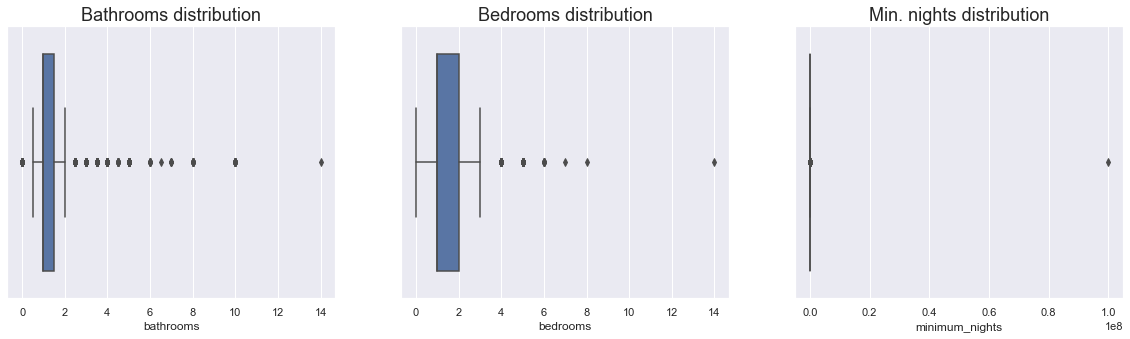

In [37]:
# visualize the tails
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# create separate plots for three columns
sns.boxplot(rentals['bathrooms'], ax=ax[0]).set_title('Bathrooms distribution', fontsize=18)
sns.boxplot(rentals['bedrooms'], ax=ax[1]).set_title('Bedrooms distribution', fontsize=18)
sns.boxplot(rentals['minimum_nights'], ax=ax[2]).set_title('Min. nights distribution', fontsize=18)

plt
plt.show()

In [38]:
# select columns with outliers in minimum_nights column
outliers = rentals[rentals['minimum_nights'] > rentals['minimum_nights'].std() * 3]

# drop outliers
rentals.drop(index=outliers.index, axis='rows', inplace=True)

# reset indices
rentals.reset_index(inplace=True, drop=True)

### Missing Values <a class="anchor" id="missing"/>

Even though it's a common practice to impute the missing values with a mean, I have some doubts about using this method. Since we are working with discrete values rather than continuous, it is worth to check the data beforehand. Let's do exactly that!

In [39]:
print(f'Mean bathrooms: {rentals["bathrooms"].mean()}')
print(f'Median bathrooms: {rentals["bathrooms"].median()}')

print('\n===\n')

print(f'Mean bedrooms: {rentals["bedrooms"].mean()}')
print(f'Median bedrooms: {rentals["bedrooms"].median()}')

Mean bathrooms: 1.3960237095579155
Median bathrooms: 1.0

===

Mean bedrooms: 1.3459166049839626
Median bedrooms: 1.0


From what we see above, indeed, using median value is more appropriate since it doesn't create a floating number. One solution would be to use "floor" operator with mean, but a simpler solution is to stick with median values. 

In [40]:
# fill in the missing values
imp = SimpleImputer(missing_values=np.nan, strategy='median')
rentals[['bathrooms', 'bedrooms']] = imp.fit_transform(rentals[['bathrooms', 'bedrooms']])

rentals.isna().sum()

id                0
latitude          0
longitude         0
property_type     0
room_type         0
bathrooms         0
bedrooms          0
minimum_nights    0
price             0
dtype: int64

### Quick Fixes <a class="anchor" id="quick"/>

Even though we have seen performed a small number of exploratory steps, we still can see a number of issues that need to be fixed beforehand. The following steps will be performed:

1. Change the "property_type" and "room_type" data types to category;
2. Drop the unnecessary "id" columns since it does not have any value;
3. Check the duplicate situation; drop them if present;
4. Alter the "price" column, convert it to numeric data type

In [41]:
# create a lambda function to apply type conversion
change_type = lambda x: x.astype('category')

rentals[['property_type', 'room_type']] = rentals[['property_type', 'room_type']].apply(change_type, axis=0)
rentals.dtypes

id                   int64
latitude           float64
longitude          float64
property_type     category
room_type         category
bathrooms          float64
bedrooms           float64
minimum_nights       int64
price               object
dtype: object

In [42]:
# check for duplicates
rentals[rentals.duplicated()]

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price


In [43]:
# drop id columns
rentals.drop('id', axis='columns', inplace=True)
assert 'id' not in rentals.columns.tolist(), 'ID is still in the dataset!'

In [44]:
# take care of the price column
rentals.price = rentals.price.apply(lambda x: x.replace('$', '').replace(',', '').strip()).astype('float64')
rentals.dtypes

latitude           float64
longitude          float64
property_type     category
room_type         category
bathrooms          float64
bedrooms           float64
minimum_nights       int64
price              float64
dtype: object

### Summary <a class="anchor" id="sum1"/>

Overall, the dataset doesn't have a lot of missing values which is great. However, it does have the following problems that need to be addressed:
- The kurtosis score is extreme for both features (bedrooms=6.7, bathrooms=29.6, and minimum nights=8111) and target (price=347.5); this shows the outlier situation. 
- Usually the bedroom/bathroom ratio is heavily correlated with the price. However, in our case, the highest correlation is 0.26 with bedrooms column, and 0.08 with bathrooms. 


I prefer an approach where each column gets treated properly. Thus, the next section is going to have a heavy data analysis. 



---
## Data Cleaning <a class="anchor" id="clean"/>
---

After having our data imputed, we can start putting it into the same format. Prior to creating the action plan, we will use some exploratory data analysis to find the best way to tackle the problem of data cleaning. 

##### First step: boxplots 

Generally, every dataset with the trio bedrooms/bathrooms/price have big correlations. Price is heavily correlated with the bedrooms count, bedrooms and bathrooms as well. Therefore, there is a need to see numeric columns' boxplots. 

##### Drop outliers 

There are two columns that will need to be treated: minimum nights and price. The first uses pandas' $value_counts()$ function to see where most data is centered. As it turns out, there majority of them fall under 32 days. Therefore, the cut drop everything bigger than 31. 
The second uses the following formula to make the cut:

$$mean \pm 3 * IQR$$

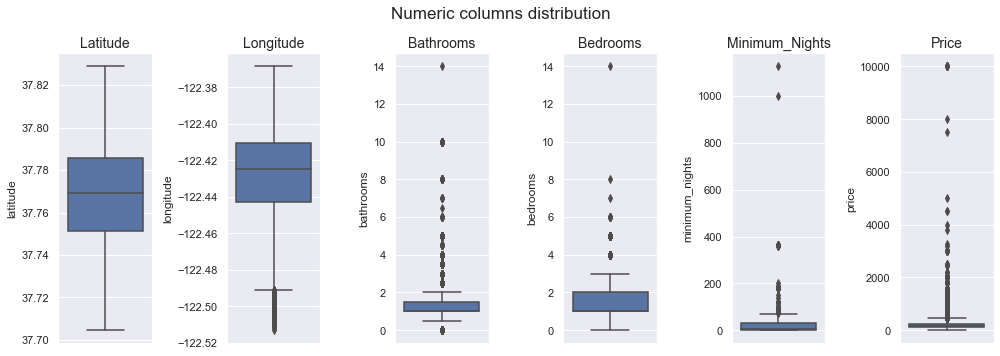

In [45]:
# select numeric columns to show
numeric = rentals.select_dtypes(np.number).columns

fig, ax = plt.subplots(1, len(numeric), figsize=(14, 5))
fig.suptitle('Numeric columns distribution', fontsize=17)

for idx in range(len(numeric)):
    sns.boxplot(data=rentals, y=numeric[idx], ax=ax[idx])
    ax[idx].set_title(numeric[idx].title(), fontsize=14)

plt.tight_layout()
plt.show()

In [46]:
# find best outlier cut for min nights
outlier = rentals[rentals['minimum_nights'] > 31]
print(f'31+ days make up {round(len(outlier) / len(rentals), 2)}%')

# show shape before drop
print('Dataset before drop:', len(rentals))

# drop min nights > 31 
rentals.drop(index=outlier.index, axis='rows', inplace=True)

# fix indexing
rentals.reset_index(inplace=True, drop=True)

# show shape before drop
print('Dataset after drop: ', len(rentals))

31+ days make up 0.02%
Dataset before drop: 8110
Dataset after drop:  7913


In [47]:
# print the possible and definite outliers for price 
suspect, outlier = outlier_detection.describe_outliers(rentals, 'price')

Price suspects (mean +- 1.5 * IQR) at: [-63.5, 365.5]
Number of suspects: 857

====

Price definite (mean +- 3.0 * IQR) outliers at: [-278.0, 580.0]
Number of outliers: 373


In [48]:
# find best outlier cut for min nights
outlier = rentals[rentals['price'] > 580]
print(f'Properties with price over $580 make up {round(len(outlier) / len(rentals), 2)}%')

# show shape before drop
print('Dataset before drop:', len(rentals))

# drop min nights > 31 
rentals.drop(index=outlier.index, axis='rows', inplace=True)

# fix indexing
rentals.reset_index(inplace=True, drop=True)

# show shape before drop
print('Dataset after drop: ', len(rentals))

Properties with price over $580 make up 0.05%
Dataset before drop: 7913
Dataset after drop:  7540


In [49]:
# look into price distribution
rentals['price'].describe()

count    7540.000000
mean      175.171088
std       105.216911
min         0.000000
25%        99.000000
50%       150.000000
75%       224.000000
max       580.000000
Name: price, dtype: float64

In [50]:
# remove free lists 
free_lists = rentals[rentals['price'] == 0].index

# drop values
rentals.drop(index=free_lists, axis='rows', inplace=True)

# reset indices
rentals.reset_index(inplace=True, drop=True)

In [51]:
# try out with std() * 3

# outlier = rentals[rentals['price'] > rentals['price'].std() * 3].index

# print(f'Properties with price over $1000 make up {round(len(outlier) / len(rentals), 2)}%')

# # show shape before drop
# print('Dataset before drop:', len(rentals))

# # drop min nights > 31 
# rentals.drop(index=outlier.index, axis='rows', inplace=True)

# # fix indexing
# rentals.reset_index(inplace=True, drop=True)

# # show shape before drop
# print('Dataset after drop: ', len(rentals))

### Bedrooms <a class="anchor" id="bedrooms"/>

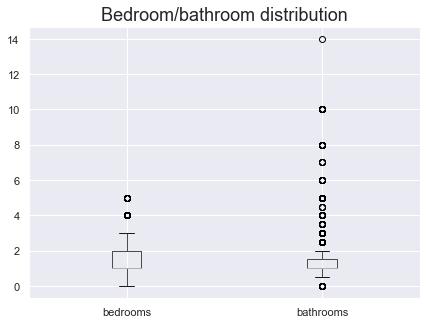

In [57]:
rentals[['bedrooms', 'bathrooms']].boxplot()\
                                  .set_title('Bedroom/bathroom distribution', fontsize=18)
plt.show()

#### 💡 Insights

- Private, shared, and hotel rooms cannot have zero OR more than 1 bedrooms, therefore we'll change the room number to 1.0
- Entire home/apt with zero rooms are studios, so we can leave them as is

# of instances: 630


Distribution of bedrooms in %
Entire home/apt    1.0
Hotel room         0.0
Private room       0.0
Shared room        0.0
Name: room_type, dtype: float64


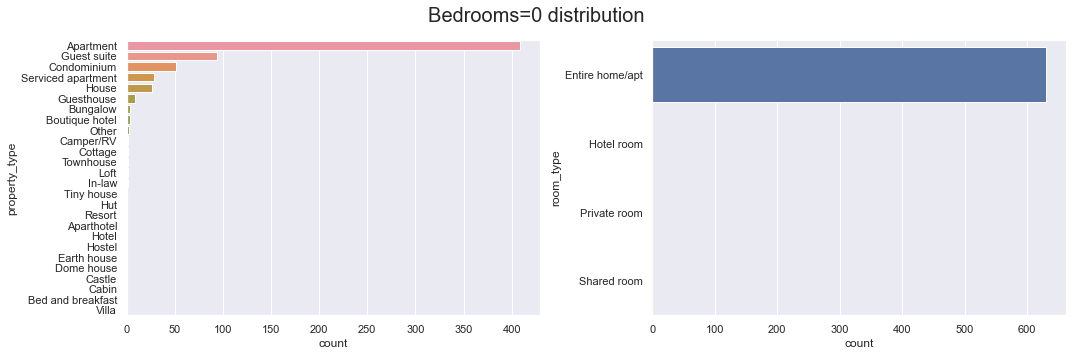

In [56]:
# look into listings with 0 bedrooms
bedrooms = rentals[rentals['bedrooms'] == 0]

# print 
print(f'# of instances: {len(bedrooms)}')
print('\n\nDistribution of bedrooms in %')
print(bedrooms.room_type.value_counts(normalize=True))

# visualize
viz.property_room(rentals, col='bedrooms', val=0)

In [54]:
# replace values where bedrooms equals 0 AND it's not an entire home
idx = rentals[(rentals['room_type'] != 'Entire home/apt') &
                 (rentals['bedrooms'] == 0)].index

rentals.loc[idx, 'bedrooms'] = 1.0

In [55]:
# set all bedrooms to 1 if it's private or shared rooms
idx = rentals[(rentals['property_type'] != 'Hotel') &
                 (rentals['room_type'] != 'Entire home/apt') &
                 (rentals['bedrooms'] > 1)].index

rentals.loc[idx, 'bedrooms'] = 1.0

### Bathrooms <a class="anchor" id="bathrooms"/>

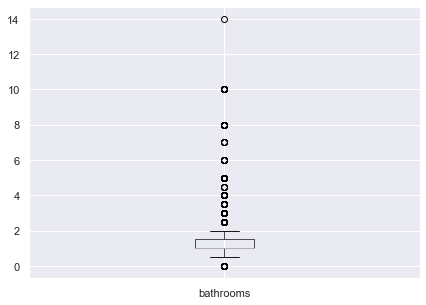

In [58]:
rentals[['bathrooms']].boxplot()
plt.show()

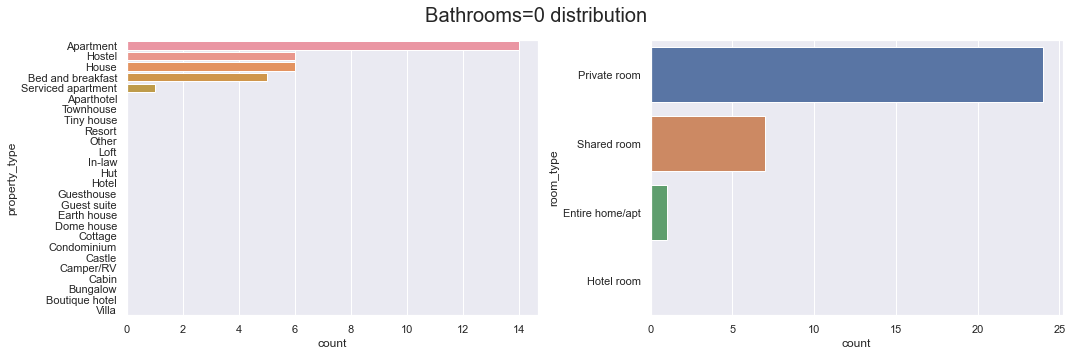

In [60]:
# show all properties with 0 bathrooms
viz.property_room(rentals, col='bathrooms', val=0)

In [61]:
# replace all 0 bathrooms to 1
rentals.bathrooms.replace(0, 1, inplace=True)

In [62]:
# impute specific cases
idx = rentals[rentals['property_type'] == 'Bed and breakfast'].index
rentals.loc[idx, 'bathrooms'] = 1.0

In [63]:
idx = rentals[(rentals['bathrooms'] > 1) & 
              (rentals['room_type'] != 'Entire home/apt')].index

rentals.loc[idx, 'bathrooms'] = 1.0

### Property type

We see below that the first 5 property types make up 90% of the dataset. Logically, if these properties get cleaned, then the overall model has to do well. I have gone through each property and selected the thresholds already, and saved the new cleaned dataset which scores over 88% without any fancy models. Let's look at their predictions capabilities!

In [66]:
rentals.property_type.value_counts(normalize=True).cumsum().head(10)

Apartment             0.407481
House                 0.689747
Condominium           0.795729
Guest suite           0.871468
Boutique hotel        0.905160
Hotel                 0.922536
Townhouse             0.939515
Serviced apartment    0.953840
Hostel                0.964186
Loft                  0.974400
Name: property_type, dtype: float64

In [67]:
properties = ['Apartment', 'House', 'Condominium', 'Guest suite', 'Boutique hotel']

# before drops 
for property_type in properties:
    temp = rentals[rentals['property_type'] == property_type]
    print(f'{property_type} accuracy score')
    quick_test.build_ols(temp, verbose=False)
    print('\n=====\n')

Apartment accuracy score
R2: 0.56

=====

House accuracy score
R2: 0.69

=====

Condominium accuracy score
R2: 0.53

=====

Guest suite accuracy score
R2: 0.36

=====

Boutique hotel accuracy score
R2: 0.28

=====



In [73]:
rentals[rentals['property_type'] == 'Apartment'].groupby('room_type').agg({'bedrooms':  np.mean,
                                                                           'bathrooms': np.mean,
                                                                           'price': [np.min, np.max, np.mean]})

bedrooms bathrooms price                   
                     mean      mean  amin   amax        mean
room_type                                                   
Entire home/apt  1.283186  1.191150  10.0  575.0  196.257522
Hotel room            NaN       NaN   NaN    NaN         NaN
Private room     1.000000  0.997308  10.0  575.0  115.989233
Shared room      1.000000  1.000000  20.0  200.0   56.260870

<AxesSubplot:xlabel='room_type', ylabel='price'>

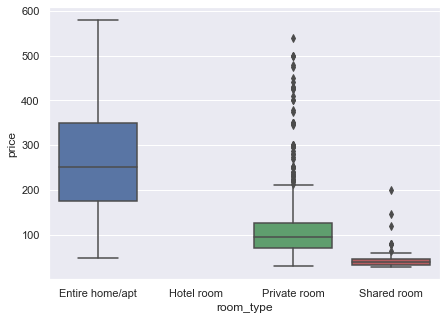

In [80]:
sns.boxplot(data=rentals[rentals['property_type'] == 'Apartment'], y='price', x='room_type') 

In [ ]:
for prop in rentals['property_type'].unique():
    df = rentals[rentals['property_type'] == prop]
    
    

In [78]:
for prop in rentals['property_type'].unique():
    df = rentals[(rentals['property_type'] == prop) & 
                 (rentals['room_type'] == 'Entire home/apt')]
    print(f'==== {prop} ====')
    print('Average number of rooms in Entire home/apt:', df['bedrooms'].mean())
    print(f'Min price: {df.price.min()}, max price: {df.price.max()}, mean: {df.price.mean()}\n')

==== Apartment ====
Average number of rooms in Entire home/apt: 1.2831858407079646
Min price: 10.0, max price: 575.0, mean: 196.2575221238938

==== House ====
Average number of rooms in Entire home/apt: 2.2949367088607593
Min price: 48.0, max price: 580.0, mean: 272.11645569620254

==== Condominium ====
Average number of rooms in Entire home/apt: 1.6355311355311355
Min price: 50.0, max price: 575.0, mean: 258.1758241758242

==== Townhouse ====
Average number of rooms in Entire home/apt: 2.2545454545454544
Min price: 70.0, max price: 549.0, mean: 266.72727272727275

==== Loft ====
Average number of rooms in Entire home/apt: 1.1454545454545455
Min price: 100.0, max price: 580.0, mean: 251.52727272727273

==== Guest suite ====
Average number of rooms in Entire home/apt: 1.0061349693251533
Min price: 39.0, max price: 500.0, mean: 160.63599182004089

==== Cottage ====
Average number of rooms in Entire home/apt: 1.2222222222222223
Min price: 75.0, max price: 449.0, mean: 256.22222222222223



In [71]:
# after drops
cleaned_df = pd.read_csv('data/cleaned_rentals.csv', index_col=0)
cleaned_df[['property_type', 'room_type']] = cleaned_df[['property_type', 'room_type']].astype('category')

# print shape 
print('Before drop shape:', rentals.shape)
print('After drop shape:', cleaned_df.shape)

# build an OLS model
quick_test.build_ols(cleaned_df, verbose=False)

Before drop shape: (7539, 8)
After drop shape: (4305, 8)
R2: 0.88


In [70]:
# after drops 
for property_type in properties:
    temp = cleaned_df[cleaned_df['property_type'] == property_type]
    print(f'{property_type} accuracy score')
    quick_test.build_ols(temp, verbose=False)
    print('\n=====\n')

Apartment accuracy score
R2: 0.91

=====

House accuracy score
R2: 0.89

=====

Condominium accuracy score
R2: 0.86

=====

Guest suite accuracy score
R2: 0.75

=====

Boutique hotel accuracy score
R2: 0.82

=====



### Exploratory Data Analysis 

##### First step: PPS scores
To see how data is related to each other, we typically use Correlation Matrix. However, our case requires something more powerful. Since Correlation Matrix can only work with numeric data, we need a tool that can reveal some insights about the categorical values! Therefore, I'm using a <a href="https://github.com/8080labs/ppscore">Power Score Matrix</a> instead. It's much more powerful in many ways, so we will stick to it. Now hidden data can no longer hide! If we see that some columns are way too correlated, we will drop them. It's never a good idea to have column duplicates.

##### Second step: insight-driven visualizations
Using insights from PPS score matrix, we will analyze the columns accordingly. 

In [ ]:
# run Predictive Power Score
pps_matrix(rentals)

#### 💡 Insights 

- Room type & minimum nights, price, property type, and bedrooms are correlated; we will need to further analyze this phenomena
- Interestingly enough, room type & property type are not heavily correlated! 
- Price & bedrooms have a weak correlation but at least it's there

### How we started <a class="anchor" id="first_model"/>

The goal of this notebook is to predict so that there prices are not more than $25 above the predictions. First, let's build the simple OLS model to see the current state of it. Then, we will use the model to make our first predictions. It will give a better sense of the work that will need to be done. 

From what see below, the model's R2 (goodness of fit) is only 51.4\% which is almost the same as the random guess. With such an accuracy, it won't be surprsing to see predictions off the chart as seen below.

In [25]:
quick_test.build_ols(rentals)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     258.6
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        20:31:08   Log-Likelihood:                -5898.5
No. Observations:                8111   AIC:                         1.187e+04
Df Residuals:                    8077   BIC:                         1.210e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0852      0.006    912.728      0.0

In [26]:
predict.sample_predict(rentals, n=10)

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price,predicted,difference (actual - predicted)
5049,37.75443,-122.46029,House,Private room,1.0,1.0,30,50.0,104.930495,-54.930495
421,37.75692,-122.41116,Loft,Entire home/apt,1.5,1.0,7,399.0,207.335661,191.664339
4912,37.79106,-122.40808,Apartment,Entire home/apt,1.0,1.0,30,140.0,208.720866,-68.720866
5448,37.77557,-122.38980,Apartment,Entire home/apt,1.0,1.0,30,281.0,198.282557,82.717443
5469,37.72489,-122.41812,Guest suite,Entire home/apt,1.0,0.0,1,120.0,84.517525,35.482475
28,37.74188,-122.43122,House,Private room,1.0,1.0,5,150.0,103.801897,46.198103
7241,37.76438,-122.44259,Apartment,Private room,1.0,1.0,2,125.0,104.960455,20.039545
541,37.80519,-122.42143,Apartment,Entire home/apt,1.0,2.0,2,298.0,401.058885,-103.058885
813,37.76458,-122.39335,Apartment,Entire home/apt,1.0,1.0,2,190.0,187.340193,2.659807
651,37.74615,-122.41673,Apartment,Private room,1.0,2.0,2,76.0,180.534686,-104.534686


### 2.2 Distributions 


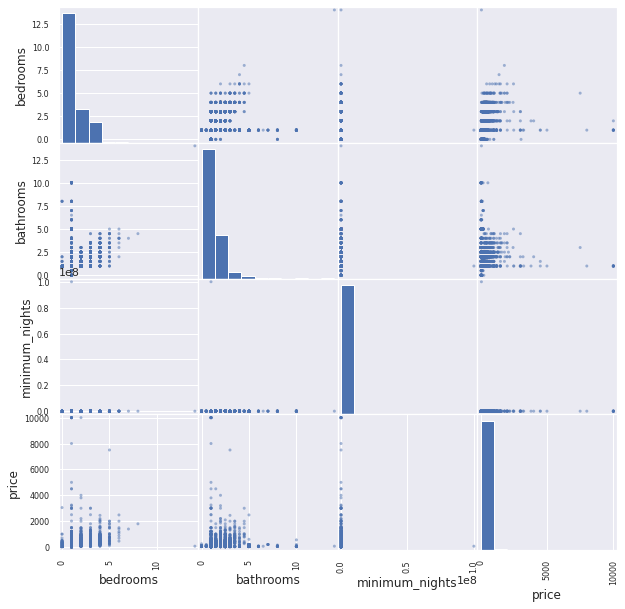

In [20]:
selected = rentals[['bedrooms', 'bathrooms', 'minimum_nights', 'price']]

scatter_matrix(selected, figsize = (10, 10))
plt.show()

### 2.5 Bedrooms 

- look into bedrooms with 0 rooms 
- look into bedrooms with > 2 rooms 


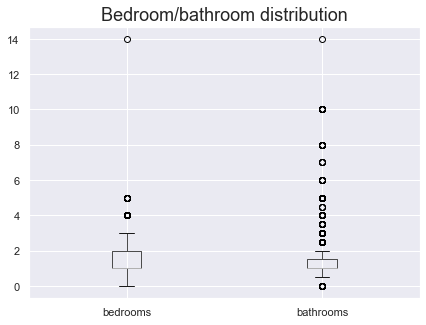

In [23]:
rentals[['bedrooms', 'bathrooms']].boxplot()\
                                  .set_title('Bedroom/bathroom distribution', fontsize=18)
plt.show()

In [24]:
# bedrooms/bathrooms correlation
np.corrcoef(rentals['bedrooms'], rentals['bathrooms'])

array([[1.        , 0.25417504],
       [0.25417504, 1.        ]])

#### Zero bedroom

- Private, shared, and hotel rooms cannot have zero bedrooms, therefore we'll change the room number to 1.0
- Entire home/apt with zero rooms are studios, so we can leave them as is

# of instances: 837


Distribution of bedrooms in %
Entire home/apt    0.752688
Private room       0.206691
Hotel room         0.040621
Shared room        0.000000
Name: room_type, dtype: float64


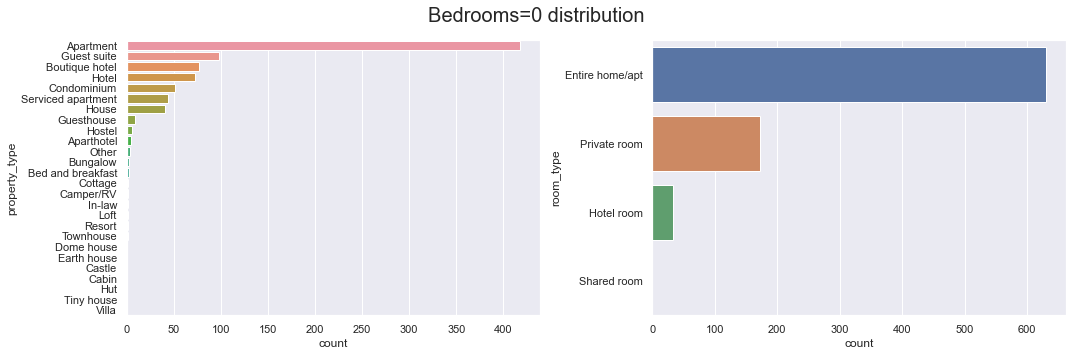

In [26]:
bedrooms = rentals[rentals['bedrooms'] == 0]

print(f'# of instances: {len(bedrooms)}')
print('\n\nDistribution of bedrooms in %')
print(bedrooms.room_type.value_counts(normalize=True))
 
viz.property_room(rentals, col='bedrooms', val=0)

In [27]:
rentals[(rentals['property_type'] != 'Hotel') &
           (rentals['room_type'] != 'Entire home/apt') &
           (rentals['bedrooms'] == 0)]

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
23,37.76212,-122.39541,House,Private room,1.0,0.0,4,125.0
261,37.80041,-122.41569,Serviced apartment,Hotel room,1.0,0.0,30,148.0
570,37.78729,-122.40944,Hostel,Private room,1.0,0.0,1,180.0
635,37.78712,-122.40960,Hostel,Private room,1.0,0.0,1,175.0
976,37.78800,-122.41146,Hostel,Private room,1.0,0.0,1,180.0
...,...,...,...,...,...,...,...,...
6936,37.77799,-122.42086,Serviced apartment,Hotel room,1.0,0.0,2,99.0
6994,37.72602,-122.43988,House,Private room,1.0,0.0,30,92.0
7016,37.71868,-122.40844,House,Private room,1.0,0.0,1,65.0
7264,37.72510,-122.40433,House,Private room,1.0,0.0,30,70.0


In [28]:
idx = rentals[(rentals['room_type'] != 'Entire home/apt') &
                 (rentals['bedrooms'] == 0)].index

rentals.loc[idx, 'bedrooms'] = 1.0

In [29]:
idx = rentals[(rentals['property_type'] != 'Hotel') &
                 (rentals['room_type'] != 'Entire home/apt') &
                 (rentals['bedrooms'] > 1)].index

rentals.loc[idx, 'bedrooms'] = 1.0

### 2.6 Bathrooms

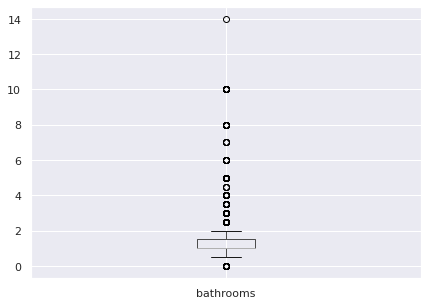

In [42]:
rentals[['bathrooms']].boxplot()
plt.show()

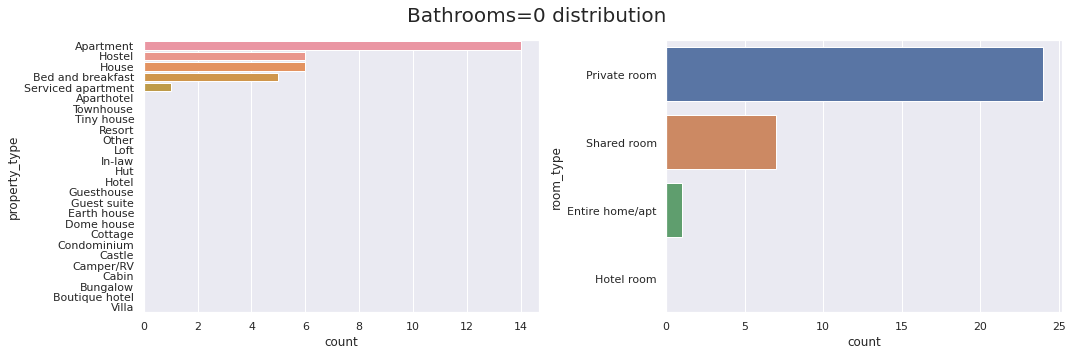

In [43]:
viz.property_room(rentals, col='bathrooms', val=0)

In [44]:
rentals.bathrooms.replace(0, 1, inplace=True)

In [45]:
idx = rentals[rentals['property_type'] == 'Bed and breakfast'].index
rentals.loc[idx, 'bathrooms'] = 1.0

In [46]:
idx = rentals[(rentals['bathrooms'] > 1) & 
                 (rentals['room_type'] != 'Entire home/apt')].index

rentals.loc[idx, 'bathrooms'] = 1.0

In [47]:
rentals.bathrooms.describe()

count    7470.000000
mean        1.153414
std         0.407650
min         0.500000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.500000
Name: bathrooms, dtype: float64

In [48]:
quick_test.build_ols(rentals, verbose=False)

R2: 0.59


### 2.7 Property types

We see below that the first 5 property types make up 90% of the dataset. Logically, if these properties get cleaned, then the overall model has to do well. I have gone through each property and selected the thresholds already, and saved the new cleaned dataset which scores over 88% without any fancy models. Let's look at their predictions capabilities!

In [49]:
rentals.property_type.value_counts(normalize=True).cumsum().head(10)

Apartment             0.408835
House                 0.690495
Condominium           0.795315
Guest suite           0.871754
Boutique hotel        0.905756
Hotel                 0.923159
Townhouse             0.939893
Serviced apartment    0.954217
Hostel                0.964525
Loft                  0.974431
Name: property_type, dtype: float64

In [50]:
properties = ['Apartment', 'House', 'Condominium', 'Guest suite', 'Boutique hotel']

# before drops 
for property_type in properties:
    temp = rentals[rentals['property_type'] == property_type]
    print(f'{property_type} accuracy score')
    quick_test.build_ols(temp, verbose=False)
    print('\n=====\n')

Apartment accuracy score
R2: 0.56

=====

House accuracy score
R2: 0.68

=====

Condominium accuracy score
R2: 0.52

=====

Guest suite accuracy score
R2: 0.36

=====

Boutique hotel accuracy score
R2: 0.28

=====



In [71]:
rentals = pd.read_csv('data/cleaned_rentals.csv', index_col=0)
rentals[['property_type', 'room_type']] = rentals[['property_type', 'room_type']].astype('category')

# build an OLS model
quick_test.build_ols(rentals, verbose=False)

R2: 0.88


In [52]:
# after drops
for property_type in properties:
    temp = rentals[rentals['property_type'] == property_type]
    print(f'{property_type} accuracy score')
    quick_test.build_ols(temp, verbose=False)
    print('\n=====\n')

Apartment accuracy score
R2: 0.91

=====

House accuracy score
R2: 0.89

=====

Condominium accuracy score
R2: 0.86

=====

Guest suite accuracy score
R2: 0.75

=====

Boutique hotel accuracy score
R2: 0.82

=====



In [53]:
predictions = predict.sample_predict(rentals, n=20)
print('Mean prediction difference:', predictions['difference (actual - predicted)'].mean())
predictions

Mean prediction difference: -41.53099082692853


,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price,predicted,difference (actual - predicted)
187,37.77023,-122.42957,Condominium,Private room,1.0,1.0,2,95.0,94.934701,0.065299
3668,37.73058,-122.43425,House,Entire home/apt,1.0,2.0,6,300.0,276.565154,23.434846
1306,37.76426,-122.46393,House,Private room,1.0,1.0,2,105.0,97.097582,7.902418
2724,37.78336,-122.43112,Apartment,Private room,1.0,1.0,30,60.0,86.770973,-26.770973
2326,37.73113,-122.38811,House,Private room,1.0,1.0,30,53.0,77.344262,-24.344262
4201,37.78784,-122.41623,House,Shared room,1.0,1.0,30,45.0,80.014600,-35.014600
1524,37.77653,-122.47387,House,Entire home/apt,1.5,2.0,30,195.0,274.196734,-79.196734
1694,37.78522,-122.40759,Aparthotel,Private room,1.0,1.0,1,70.0,145.785192,-75.785192
3383,37.77357,-122.41631,House,Shared room,1.0,1.0,30,40.0,77.509483,-37.509483
2797,37.76901,-122.42277,House,Private room,1.0,1.0,30,115.0,82.943389,32.056611


## 3.1 Feature selection

In [54]:
print('Current predictions accuracy')
quick_test.build_ols(rentals, verbose=False)

Current predictions accuracy
R2: 0.88


In [59]:
X, y = rentals.drop('price', axis='columns'), rentals['price']
y = np.log1p(y)

X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

estimator = SVR(kernel="linear")
selector = RFE(estimator, step=1)
selector = selector.fit(X_train, y_train)
selector.support_

array([ True, False,  True,  True,  True,  True,  True, False,  True,
       False, False,  True, False, False, False,  True, False,  True,
        True,  True, False, False, False, False, False, False, False,
        True, False,  True,  True,  True])

In [63]:
mask = selector.support_
print('Columns to drop:')
X.columns[~mask].tolist()

Columns to drop:


['longitude',
 'property_type_Boutique hotel',
 'property_type_Cabin',
 'property_type_Castle',
 'property_type_Cottage',
 'property_type_Dome house',
 'property_type_Earth house',
 'property_type_Guesthouse',
 'property_type_Hut',
 'property_type_In-law',
 'property_type_Loft',
 'property_type_Other',
 'property_type_Resort',
 'property_type_Serviced apartment',
 'property_type_Tiny house',
 'property_type_Villa']

In [72]:
rentals.drop('longitude', axis='columns', inplace=True)
rentals = rentals[~rentals['property_type'].isin(
    ['Boutique hotel', 'Cabin', 'Castle', 'Cottage',
     'Dome house', 'Guesthouse', 'Hut', 'In-law', 'Loft',
     'Other', 'Resort', 'Serviced apartment', 'Tiny house', 'Villa'])]

In [73]:
rentals.property_type.cat.remove_unused_categories(inplace=True)
rentals.room_type.cat.remove_unused_categories(inplace=True)

quick_test.build_ols(cleaned_df)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     1964.
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:40:05   Log-Likelihood:                 659.92
No. Observations:                4116   AIC:                            -1284.
Df Residuals:                    4098   BIC:                            -1170.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8926      0.003   1519.478      0.0

### 4. Build model

In [74]:
X, y = rentals.drop('price', axis='columns'), rentals['price']

y = np.log1p(y)
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
scale = StandardScaler()

X_train = scale.fit_transform(X_train)
X_test = scale.fit_transform(X_test)

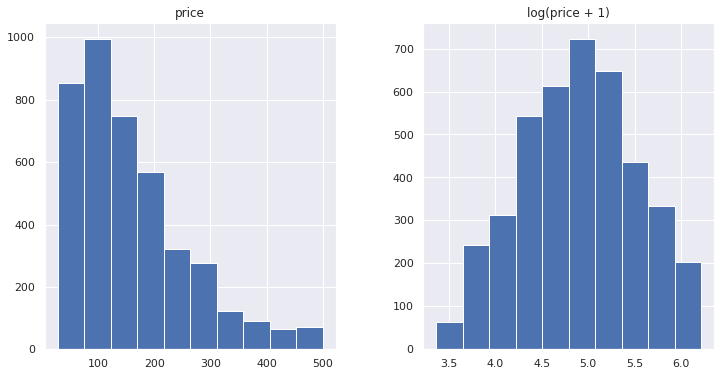

In [75]:
# plot unnormalized and normalized price columns
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({'price': rentals['price'], 
                       'log(price + 1)': np.log1p(rentals['price'])})
prices.hist()
plt.show()

In [76]:
# temp = cleaned_df.copy()
target = cleaned_df.price
target = np.log1p(cleaned_df['price'])

cleaned_df.drop('price', axis='columns', inplace=True)
skewed_features = cleaned_df.select_dtypes(include=np.number).apply(lambda x: skew(x))
skewed_features

latitude         -0.330223
bathrooms         2.751428
bedrooms          1.485076
minimum_nights    0.154602
dtype: float64

In [77]:
skewed_features = skewed_features[skewed_features > 0.75].index
cleaned_df[skewed_features] = np.log1p(cleaned_df[skewed_features])

In [78]:
cleaned_df = pd.get_dummies(cleaned_df)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_df, target, test_size=0.25)


In [82]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [83]:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

Text(0, 0.5, 'rmse')

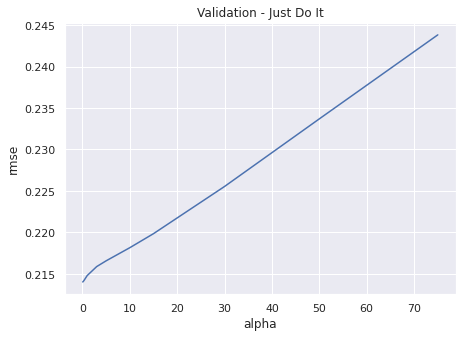

In [84]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [85]:


cv_ridge.min()



0.21402767545252996

In [86]:


model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)

rmse_cv(model_lasso).mean()

0.21600637895288757

In [87]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [88]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 17 variables and eliminated the other 2 variables


In [89]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

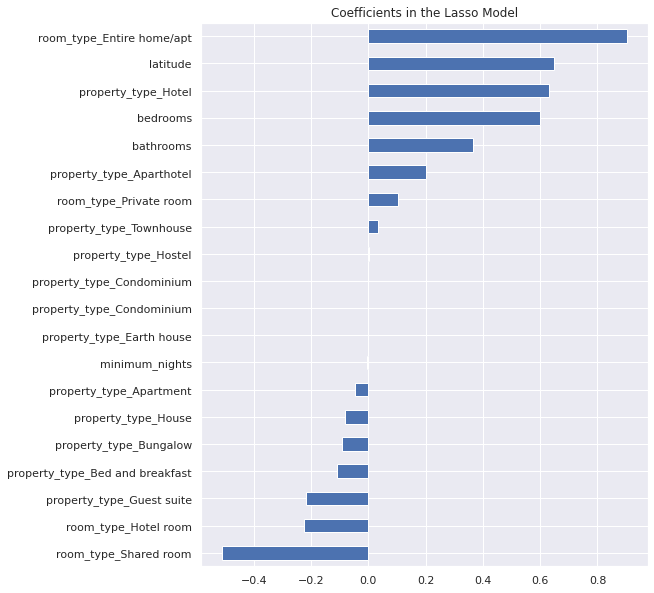

In [90]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='preds', ylabel='residuals'>

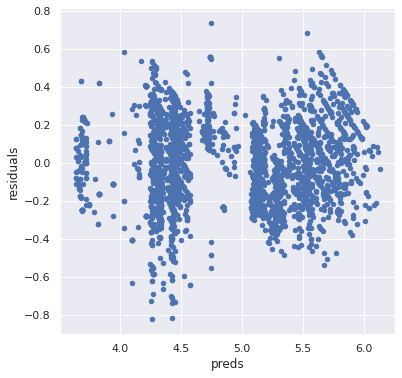

In [91]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")


In [92]:
model_xgb = xgb.XGBRegressor(n_estimators=400, max_depth=4, learning_rate=0.1) 
model_xgb.fit(X_train, y_train)



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=400, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [93]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='xgb', ylabel='lasso'>

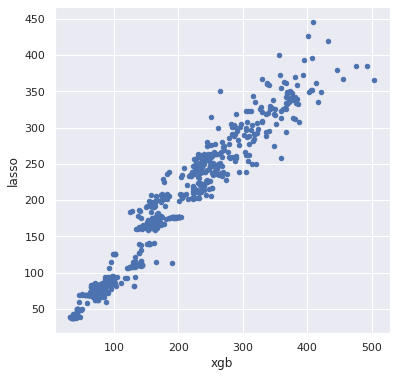

In [94]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [95]:
predictions['actual'] = np.expm1(y_test)

In [96]:
predictions

,xgb,lasso,actual
0,166.507385,181.402956,170.0
1,145.797791,165.425486,99.0
2,65.010551,72.684807,235.0
3,273.604553,227.731204,225.0
4,79.421600,73.954240,120.0
...,...,...,...
1024,247.844940,243.302461,NaN
1025,82.248268,81.925384,NaN
1026,142.951050,164.708631,95.0
1027,157.546616,162.602594,NaN


In [97]:
model_xgb.score(X_test, y_test)

0.9010845721218782

In [98]:
sample = temp.sample(n=10)
sample

,latitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
3935,37.74232,House,Private room,1.0,1.0,30,70.0
2490,37.79103,Apartment,Entire home/apt,1.0,1.0,30,181.0
3821,37.76068,Apartment,Private room,1.0,1.0,3,110.0
3688,37.77338,Condominium,Entire home/apt,1.0,2.0,2,250.0
2269,37.75805,Apartment,Entire home/apt,1.0,1.0,4,160.0
164,37.76197,Apartment,Entire home/apt,1.0,1.0,30,170.0
4095,37.75868,Apartment,Entire home/apt,1.0,1.0,30,157.0
1458,37.75958,House,Entire home/apt,1.5,2.0,3,348.0
3661,37.78712,Condominium,Entire home/apt,1.5,1.0,2,145.0
2561,37.74041,House,Entire home/apt,1.0,2.0,3,350.0


In [103]:
X_sample = sample.drop('price', axis='columns')
X_sample = pd.get_dummies(X_sample)

In [104]:
np.expm1(model_xgb.predict(X_sample))

array([ 71.38083, 232.60783,  97.93333, 526.14044, 284.23126, 237.69916,
       237.79933, 402.28973, 325.40808, 457.3699 ], dtype=float32)

In [105]:
sample['predicted'] = np.expm1(model_xgb.predict(X_sample))

In [106]:
sample['difference'] = sample['price'] - sample['predicted']

In [107]:
sample

,latitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price,predicted,difference
3935,37.74232,House,Private room,1.0,1.0,30,70.0,71.380829,-1.380829
2490,37.79103,Apartment,Entire home/apt,1.0,1.0,30,181.0,232.607834,-51.607834
3821,37.76068,Apartment,Private room,1.0,1.0,3,110.0,97.933327,12.066673
3688,37.77338,Condominium,Entire home/apt,1.0,2.0,2,250.0,526.140442,-276.140442
2269,37.75805,Apartment,Entire home/apt,1.0,1.0,4,160.0,284.231262,-124.231262
164,37.76197,Apartment,Entire home/apt,1.0,1.0,30,170.0,237.699158,-67.699158
4095,37.75868,Apartment,Entire home/apt,1.0,1.0,30,157.0,237.799332,-80.799332
1458,37.75958,House,Entire home/apt,1.5,2.0,3,348.0,402.289734,-54.289734
3661,37.78712,Condominium,Entire home/apt,1.5,1.0,2,145.0,325.408081,-180.408081
2561,37.74041,House,Entire home/apt,1.0,2.0,3,350.0,457.369904,-107.369904
